## Check CUDA Device Usage

In [1]:
!nvidia-smi

Mon Feb 12 20:49:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8               9W /  95W |      2MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

if torch.cuda.is_available():
    print(torch.cuda.current_device())

0


## Visualize Data

In [1]:
from datasets import load_dataset
from tokenizers import ByteLevelBPETokenizer

import matplotlib.pyplot as plt

/home/leocftian/programs/image-2-latex/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("./data/im2latex-100k", trust_remote_code=True)

Dataset({
    features: ['formula', 'filename', 'image'],
    num_rows: 55033
})
\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=320x64 at 0x7F9E5710C650>


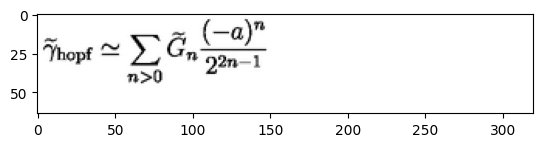

In [22]:
print(dataset["train"])

print(dataset["train"][0]["formula"])
plt.imshow(dataset["train"][0]["image"])

print(dataset["train"][2]["image"])

## Initialize Directories

In [6]:
import os

if not os.path.exists("./tokenizer/"):
  os.mkdir("./tokenizer/")

if not os.path.exists("./model/"):
  os.mkdir("./model/")

## Train Tokenizer

In [7]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

In [8]:
# Train tokenizer from dataset
tokenizer = ByteLevelBPETokenizer()
tokenizer.train_from_iterator(
    dataset["train"]["formula"],
    vocab_size=30_000,
    min_frequency=5,
    show_progress=True,
    special_tokens=[
                    "<s>",
                    "<pad>",
                    "</s>",
                    "<unk>",
                    "<mask>",
    ]
)

tokenizer.save_model("./tokenizer/")

# Reload and wrap Tokenizer
tokenizer = ByteLevelBPETokenizer(
    "./tokenizer/vocab.json",
    "./tokenizer/merges.txt",
)
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

print(tokenizer.encode(dataset["train"][0]["formula"]))




Encoding(num_tokens=60, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


## Initialize Model

In [9]:
from transformers import RobertaConfig, RobertaForMaskedLM

In [10]:
config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

model = RobertaForMaskedLM(config=config)
print('Num parameters: ',model.num_parameters())

Num parameters:  49816064


In [12]:
from transformers import Trainer, TrainingArguments, RobertaTokenizerFast, DataCollatorForLanguageModeling
from torch.utils.data import Dataset
import torch

In [12]:
class FormulaDataset(Dataset):
    def __init__(self, data, tokenizer = None):
        if (tokenizer == None):
          tokenizer = ByteLevelBPETokenizer(
              "./tokenizer/vocab.json",
              "./tokenizerr/merges.txt",
          )
          tokenizer._tokenizer.post_processor = BertProcessing(
              ("</s>", tokenizer.token_to_id("</s>")),
              ("<s>", tokenizer.token_to_id("<s>")),
          )
          tokenizer.enable_truncation(max_length=512)

        self.examples = [x.ids for x in tokenizer.encode_batch(data)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i])

# Create the train and evaluation dataset
train_dataset = FormulaDataset(dataset['train']['formula'], tokenizer)
eval_dataset = FormulaDataset(dataset['val']['formula'], tokenizer)

In [27]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=RobertaTokenizerFast.from_pretrained("./tokenizer", max_length=512), mlm=True, mlm_probability=0.15
)

In [14]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./model",
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=10,
    learning_rate=0.0005,
    weight_decay=0,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    save_steps=2048,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
# Train the model
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss
1,1.939100,1.488839
2,1.236100,1.042968
3,1.011300,0.917273
4,0.913500,0.844856
5,0.832900,0.782962
6,0.794800,0.741702
7,0.745300,0.709064
8,0.725500,0.669355
9,0.690100,0.660690
10,0.680700,0.656438


TrainOutput(global_step=17200, training_loss=1.0422109018370163, metrics={'train_runtime': 6167.7918, 'train_samples_per_second': 89.226, 'train_steps_per_second': 2.789, 'total_flos': 1.6221258774296064e+16, 'train_loss': 1.0422109018370163, 'epoch': 10.0})

In [18]:
trainer.save_model("./model")
RobertaTokenizerFast.from_pretrained("./tokenizer", max_length=512).save_pretrained("./tokenizer")

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.json',
 './tokenizer/merges.txt',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [21]:
from transformers import pipeline
# Create a Fill mask pipeline
fill_mask = pipeline(
    "fill-mask",
    model="./model",
    tokenizer="./tokenizer"
)

fill_mask("\\frac { \\mathrm { d } x ^ 2 } { \\mathrm { d } x } = <mask>")

[{'score': 0.9174398183822632,
  'token': 284,
  'token_str': ' 0',
  'sequence': '\\frac { \\mathrm { d } x ^ 2 } { \\mathrm { d } x } = 0'},
 {'score': 0.04172337055206299,
  'token': 271,
  'token_str': ' 1',
  'sequence': '\\frac { \\mathrm { d } x ^ 2 } { \\mathrm { d } x } = 1'},
 {'score': 0.004636840429157019,
  'token': 266,
  'token_str': ' 2',
  'sequence': '\\frac { \\mathrm { d } x ^ 2 } { \\mathrm { d } x } = 2'},
 {'score': 0.0033619140740484,
  'token': 273,
  'token_str': ' -',
  'sequence': '\\frac { \\mathrm { d } x ^ 2 } { \\mathrm { d } x } = -'},
 {'score': 0.0018731600139290094,
  'token': 318,
  'token_str': ' c',
  'sequence': '\\frac { \\mathrm { d } x ^ 2 } { \\mathrm { d } x } = c'}]

In [3]:
from transformers import RobertaConfig, ViTConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

In [4]:
config_encoder = ViTConfig()
config_decoder = RobertaConfig.from_pretrained("./model")
config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

In [5]:
model = VisionEncoderDecoderModel(config=config)

# Accessing the model configuration
config_encoder = model.config.encoder
config_decoder = model.config.decoder
# set decoder config to causal lm
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

In [6]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms

In [7]:
from torchvision.transforms import Compose, Normalize, ToTensor
from transformers import ViTImageProcessor

processor = ViTImageProcessor()

image_mean, image_std = processor.image_mean, processor.image_std
normalize = Normalize(mean=image_mean, std=image_std)
transforms = Compose( [ ToTensor(), normalize, ] )

In [8]:
class OCRDataset(Dataset):
    def __init__(self, data, tokenizer, transforms = None):
        self.data = data
        self.tokenizer = tokenizer
        self.transforms = transforms
        
        self.examples = {}
        
        self.examples["labels"] = [x.ids for x in tokenizer.encode_batch(data["formula"], padding=True)]
        self.examples["pixel_values"] = data["image"]
        
    def __getitem__(self, idx):
        batch = {}
        batch['labels'] = torch.tensor(self.examples["labels"][idx])
        
        if self.transforms:
            batch['pixel_values'] = self.transforms(self.examples["pixel_values"][idx])
        else:
            batch['pixel_values'] = self.examples["pixel_values"][idx]
        
        return batch

    def __len__(self):
        return len(self.data)
    
tokenizer = ByteLevelBPETokenizer(
    "./tokenizer/vocab.json",
    "./tokenizer/merges.txt",
)
tokenizer.enable_truncation(max_length=512)
    
train_dataset = OCRDataset(dataset['train'], tokenizer, transforms)
eval_dataset = OCRDataset(dataset['val'], tokenizer, transforms)

In [9]:
from transformers import default_data_collator, Trainer, TrainingArguments

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./transformer-model",
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=10,
    learning_rate=0.0005,
    weight_decay=0,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    save_steps=2048,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator = default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
# Train the model
trainer.train()

RuntimeError: stack expects each tensor to be equal size, but got [28] at entry 0 and [65] at entry 1